### Introduction

I have used simple techniques to classify text.There are many model/techniques which are used but here i have used simple approach so that one can understand easily how to preprocess and classify text  but here

this data contains 6 fields which are as follows:

1. target: The polarity of the tweet
2. ids: The id of the tweets
3. date: date of the tweets
4. flag: The querry
5. user: The user that tweeted
6. text: The text of the tweet

Import the Dependencies

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

import string

import nltk
from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

Load the datasets

In [2]:
cols=['target','ids','date','flag','user','text']
tweets=pd.read_csv('tweets.csv',encoding='latin',names=cols)

In [3]:
tweets.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


This dataset contains 6 columns but for our test classification we just need two columns namely `target` and `text`

shape of the data

In [4]:
tweets.shape

(1600000, 6)

#### Data Augmentation

In [5]:
tweets_data=tweets[['target','text']]

In [6]:
tweets_data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


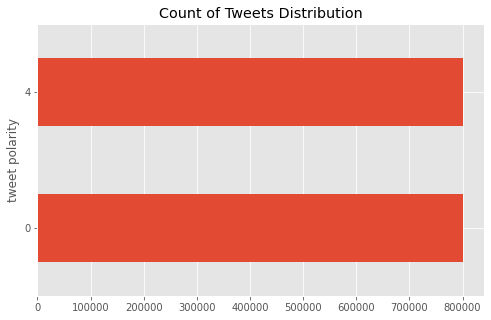

In [7]:
ax=tweets_data['target'].value_counts() .plot(kind='barh',
                                           title='Count of Tweets Distribution',
                                           figsize=(8,5))
ax.set_ylabel('tweet polarity')
plt.show()

In [8]:
# view the first row through indexing
tweets_data['text'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## Explanatory Data Analysis

Data information

In [9]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


checking null values

In [10]:
tweets_data.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
tweets_data.target.unique()

array([0, 4], dtype=int64)

distribution of the data

[Text(0, 0, 'Negative'), Text(0, 1, 'Positive')]

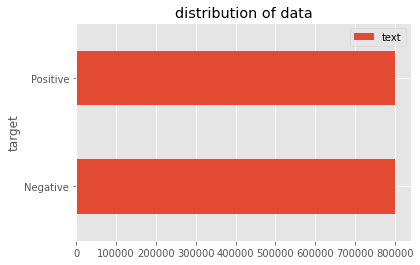

In [12]:
tweets_data.groupby('target').count().plot(kind='barh',title='distribution of data').set_yticklabels(['Negative','Positive'],rotation=0)

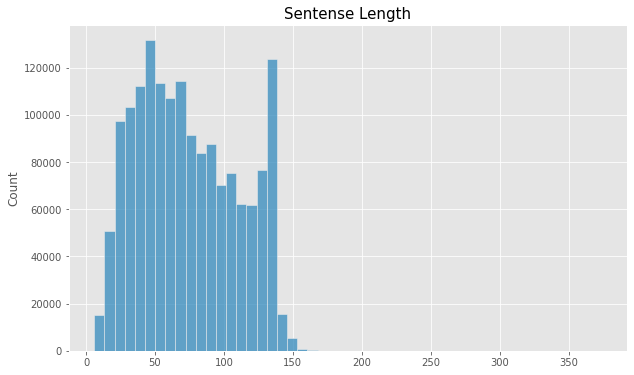

In [13]:
# sentence length plot

plt.figure(figsize=(10,6))
ax=sns.histplot([len(s) for s in tweets_data.text],bins=50,palette='Set1')
ax.set_title('Sentense Length',fontsize=15)
plt.show()

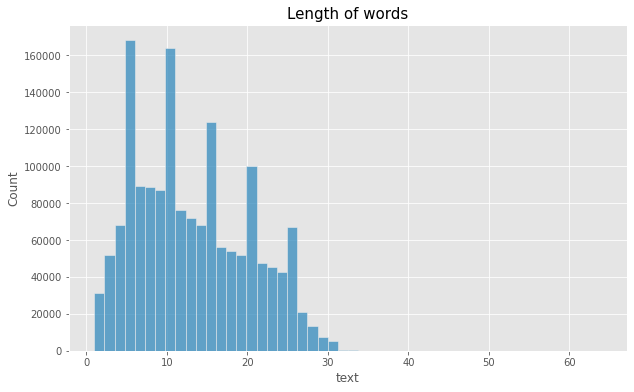

In [14]:
# hist of lenght of words
plt.figure(figsize=(10,6))
ax=sns.histplot((tweets_data.text.str.split().map(lambda x: len(x))),bins=50,palette='Set1')
ax.set_title('Length of words',fontsize=15)
plt.show()

### Data Cleaning and Feature Engineering

In [15]:
data_pos = tweets_data[tweets_data['target'] == 1]
data_neg = tweets_data[tweets_data['target'] == 0]

In [16]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [17]:
dataset = pd.concat([data_pos, data_neg])

Making statement text in lowercase

In [18]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [19]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [20]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass no, it's not behaving all. i'...
Name: text, dtype: object

In [21]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [22]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [23]:
def clean_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s+]+))',' ',text)

dataset.text=dataset.text.apply(clean_URLs)
dataset.text.head()

0    switchfoot httptwitpiccom21zl  a s bummer shou...
1    upset cant update facebook texting it might cr...
2    kenichan dived many times ball managed save 50...
3                     whole body feels itchy like fire
4    nationwideclass no its not behaving all im mad...
Name: text, dtype: object

In [24]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [25]:
# Removing stop words using nltk lib


#Tokenization of text
tokenizer=ToktokTokenizer() 

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#Removing standard english stopwords like prepositions, adverbs
stop = set(stopwords.words('english'))
print("NLTK stop word lists \n")
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
dataset['text']=dataset['text'].apply(remove_stopwords)


NLTK stop word lists 

{'weren', 'were', 'out', "hasn't", 'you', 'the', 'are', 'd', 'some', 'we', 'while', 'because', 'all', 'mustn', 'mightn', 'was', "haven't", 'did', 'then', "weren't", 'more', "it's", 'until', 'that', 'own', 'your', 't', 'me', 'have', "you'll", "you're", 'such', 'once', 'no', 've', 'shouldn', 'can', 'and', 'above', "shouldn't", 'do', 'has', 'where', 'will', 'haven', 'again', 'but', 'don', 'doesn', 'from', 'during', 'than', 'couldn', 'itself', 'been', 'should', 'yourselves', 'very', 'most', 'to', 'any', 'nor', 'wouldn', 'other', "needn't", 'ain', "shan't", 'y', 'having', 'just', 'so', 'himself', 'they', 'these', "wasn't", "mustn't", 'his', 'through', "wouldn't", "couldn't", 'he', 'didn', 'if', 'when', 'is', 'after', 'too', 'each', 'be', 'not', "you'd", 're', "she's", 'in', 'which', 'about', 'up', 'had', 'does', "doesn't", 'ourselves', 'between', 'below', 'myself', "isn't", 'by', 'into', 'wasn', 'same', 'who', 'for', "should've", 'aren', 'their', 'of', 'hadn', 'those'

Getting tokenization of tweet text

In [26]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

0    [switchfoot, httptwitpiccomzl, bummer, shoulda...
1    [upset, cant, update, facebook, texting, might...
2    [kenichan, dived, many, times, ball, managed, ...
3              [whole, body, feels, itchy, like, fire]
4      [nationwideclass, behaving, im, mad, cant, see]
Name: text, dtype: object

Applying stemming

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
tweets_data['text']= tweets_data['text'].apply(lambda x: stemming_on_text(x))
tweets_data['text'].head()

Applying lemmatizer

lm = nltk.WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmatized_tokens=[lm.lemmatize(word) for word in tokens]
    return lemmatized_tokens

tweets_data.text=tweets_data.text.apply(lemmatize_tokens)
tweets_data.text.head()

Separating input feature and label

In [28]:
X=tweets_data.text
y=tweets_data.target

splitting the dataset into train and test

In [29]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

Fit the TF-IDF Vectorizer

In [30]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

Transforming the dataset using TF-IDF

In [31]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [32]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

In [35]:
y_pred = LRmodel.predict(X_test)

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           4       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

